# Passing data sets between Hail and Scanpy

In [1]:
import scanpy.api as sc

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt

import hail as hl
from bokeh.io import output_notebook, show

In [2]:
hl.init()

using hail jar at /Users/gokcen/anaconda3/lib/python3.6/site-packages/hail/hail-all-spark.jar
Running on Apache Spark version 2.2.2
SparkUI available at http://10.90.148.35:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.9-8588a25687af
LOGGING: writing to /Users/gokcen/Code/hail-scanpy/hail-20190205-0919-0.2.9-8588a25687af.log


In [3]:
def mt2ad(mt, genotype_entry_field='GT'):
    row_keys = list(mt.row_key)
    col_keys = list(mt.col_key)
    
    row_df = mt.key_rows_by().rows().to_pandas(flatten=False)
    row_df = _df_index_list_to_tuple(row_df, row_keys)
    row_df.set_index(row_keys, inplace=True)
    
    col_df = mt.key_cols_by().cols().to_pandas(flatten=False)
    col_df = _df_index_list_to_tuple(col_df, col_keys)
    col_df.set_index(col_keys, inplace=True)

    X_df = _mt_entry_to_df(mt, genotype_entry_field=genotype_entry_field)

    assert X_df.index.equals(col_df.index)
    assert X_df.columns.equals(row_df.index)

    # TODO: add other entry fields to adata.layers
    # TODO: add mt.globals to adata.uns
    
    return sc.AnnData(X_df.values, obs=col_df, var=row_df)


def _mt_entry_to_df(mt, genotype_entry_field='GT'):
    assert genotype_entry_field in list(mt.entry)
    
    ngt = '_' + genotype_entry_field + '_anndata'
    mt = mt.annotate_entries(**{ngt: mt[genotype_entry_field].n_alt_alleles()})
    
    # this explodes after 1000 x 500  ¯\_(ツ)_/¯
    df = mt.select_entries(ngt).make_table('<<').to_pandas(flatten=False)
    
    keys = list(mt.row_key)
    other_row_fields = list(mt.row_value)
    
    df.drop(other_row_fields, axis=1, inplace=True, errors='ignore')
    df.columns = [x.split('<<')[0] for x in df.columns]
    df = _df_index_list_to_tuple(df, keys)
    
    return df.set_index(keys).T


def _df_index_list_to_tuple(df, keys):
    for key in keys:
        if isinstance(df[key][0], list):
            df[key] = [tuple(x) for x in df[key]]
    return df

## Simulate genotypes

In [4]:
hl.set_global_seed(1)
smt = hl.methods.balding_nichols_model(n_populations=3, 
                                       n_samples = 1000, 
                                       n_variants = 500, 
                                       mixture=True)
smt = smt.annotate_cols(s=hl.str(smt.sample_idx)).key_cols_by('s') # make_table needs a single str col key
smt = smt.drop(smt.bn) # workaround for https://github.com/hail-is/hail/issues/5212
smt.describe()

2019-02-05 09:19:41 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 1000 samples, and 500 variants...


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'sample_idx': int32 
    'pop': array<float64> 
    's': str 
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'ancestral_af': float64 
    'af': array<float64> 
----------------------------------------
Entry fields:
    'GT': call 
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
----------------------------------------


In [5]:
ad = mt2ad(smt)
ad

2019-02-05 09:19:44 Hail: INFO: Coerced sorted dataset
2019-02-05 09:19:47 Hail: INFO: Coerced sorted dataset
2019-02-05 09:19:48 Hail: INFO: Coerced sorted dataset
2019-02-05 09:19:51 Hail: INFO: Coerced sorted dataset


AnnData object with n_obs × n_vars = 1000 × 500 
    obs: 'sample_idx', 'pop'
    var: 'ancestral_af', 'af'

In [6]:
ad.obs['pop_argmax'] = [np.argmax(x) for x in ad.obs['pop'].values]
ad.obs.pop_argmax = ad.obs.pop_argmax.astype('category')

### Clustering, PCA and Diffusion Maps

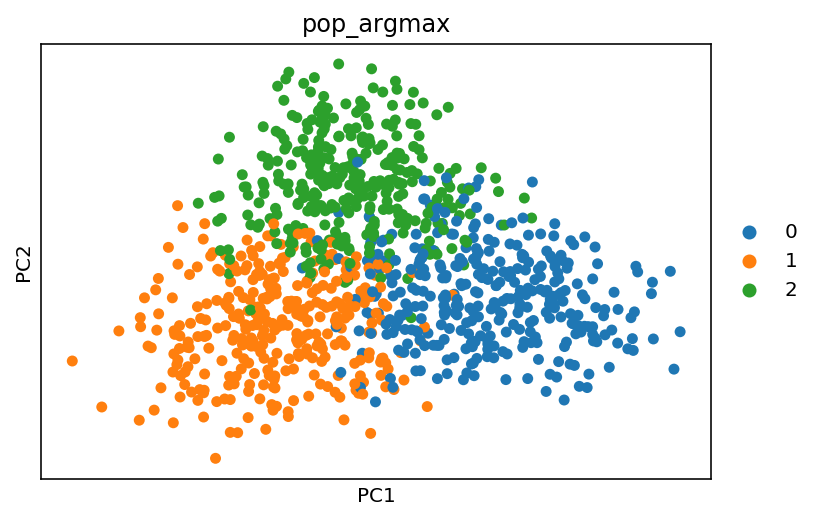

In [7]:
sc.pp.pca(ad)
sc.pl.pca(ad, color='pop_argmax')

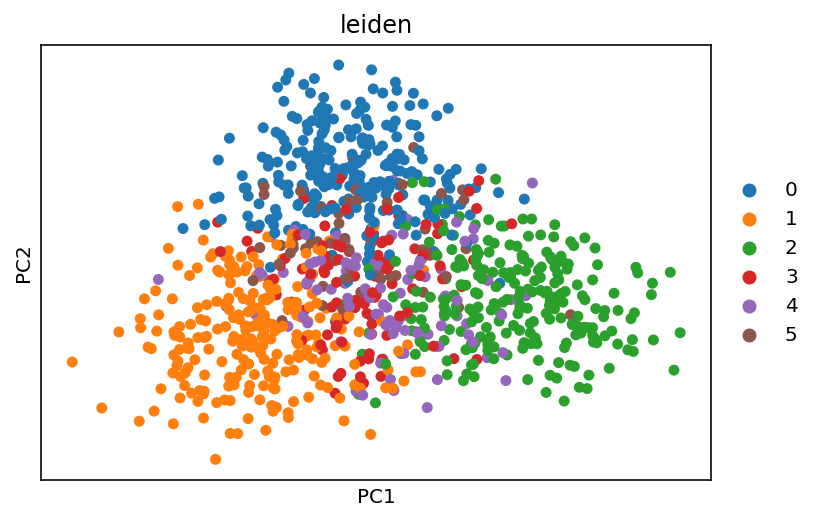

In [8]:
sc.pp.neighbors(ad)
sc.tl.leiden(ad)
sc.pl.pca(ad, color='leiden')

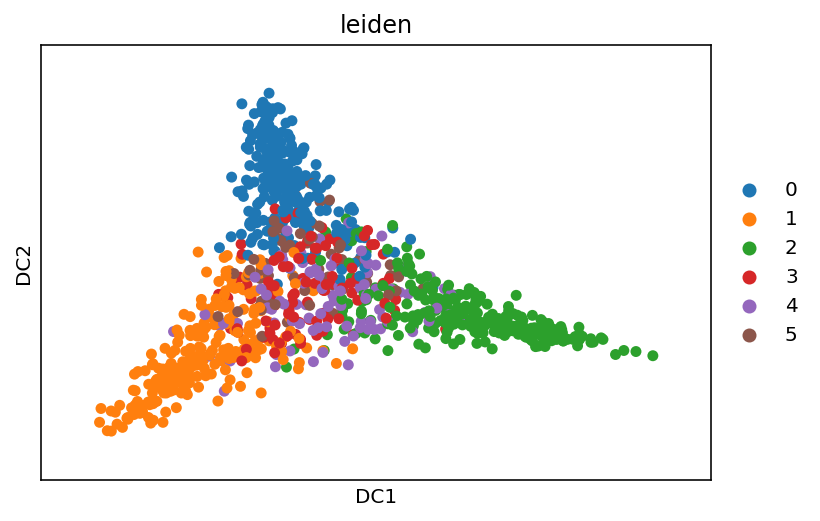

In [9]:
sc.tl.diffmap(ad)
sc.pl.diffmap(ad, color='leiden')

### LD

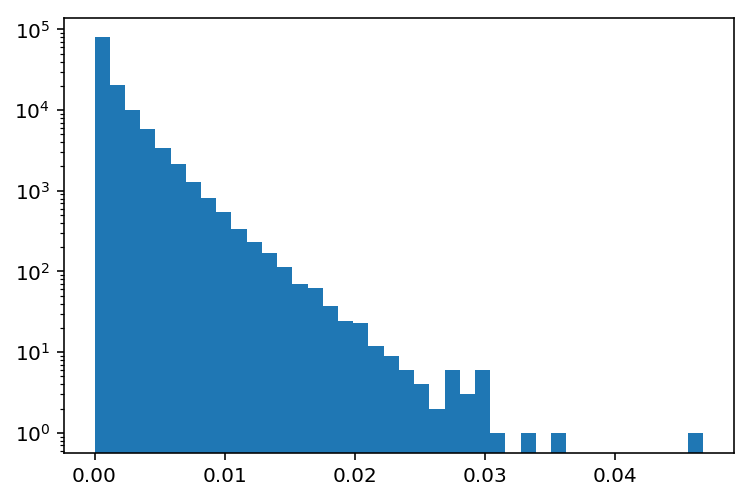

In [10]:
c = np.corrcoef(ad.X.T)**2 # squared variant correlations
plt.hist(c[np.triu_indices(len(c), 1)], bins=40);
plt.yscale("log", nonposy='clip')

## 1000 Genomes

In [11]:
hl.utils.get_1kg('data/')
mt = hl.read_matrix_table('Data/1kg.mt/')
mt.describe()

2019-02-05 09:20:05 Hail: INFO: downloading 1KG VCF ...
  Source: https://storage.googleapis.com/hail-tutorial/1kg.vcf.bgz
2019-02-05 09:22:02 Hail: INFO: importing VCF and writing to matrix table...
2019-02-05 09:22:03 Hail: INFO: Coerced sorted dataset
2019-02-05 09:22:05 Hail: INFO: wrote matrix table with 10961 rows and 284 columns in 16 partitions to data/1kg.mt
2019-02-05 09:22:05 Hail: INFO: downloading 1KG annotations ...
  Source: https://storage.googleapis.com/hail-tutorial/1kg_annotations.txt
2019-02-05 09:22:06 Hail: INFO: downloading Ensembl gene annotations ...
  Source: https://storage.googleapis.com/hail-tutorial/ensembl_gene_annotations.txt


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str 
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    } 
----------------------------------------
Entry fields:
    'GT': call 
    'AD': array<int32> 
    'DP': int32 
    'GQ': int32 
    'PL': array<int32> 
---------------------------------

2019-02-05 09:22:24 Hail: INFO: Done!


In [12]:
adata = mt2ad(mt)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 284 × 10961 
    var: 'rsid', 'qual', 'filters', 'info'

In [13]:
# read sample annotations and add to adata.obs
annot = pd.read_table('data/1kg_annotations.txt', index_col='Sample')
adata.obs = adata.obs.join(annot)
adata.obs.head()

,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption
s,,,,,
HG00096,GBR,EUR,False,False,4
HG00099,GBR,EUR,True,False,4
HG00105,GBR,EUR,False,False,4
HG00118,GBR,EUR,True,False,3
HG00129,GBR,EUR,False,False,6


In [14]:
def simple_mode_impute(ad):
    m, c = sp.stats.mode(ad.X, nan_policy='omit')
    modes = m.data

    inds = np.where(np.isnan(ad.X))
    ad.X[inds] = np.take(modes, inds[1])
    
    return ad

In [15]:
adata = simple_mode_impute(adata) # we have to impute nans ¯\_(ツ)_/¯
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.]], dtype=float32)

### Clustering and PCA

... storing 'Population' as categorical
... storing 'SuperPopulation' as categorical
... storing 'rsid' as categorical
... storing 'filters' as categorical
... storing 'info' as categorical


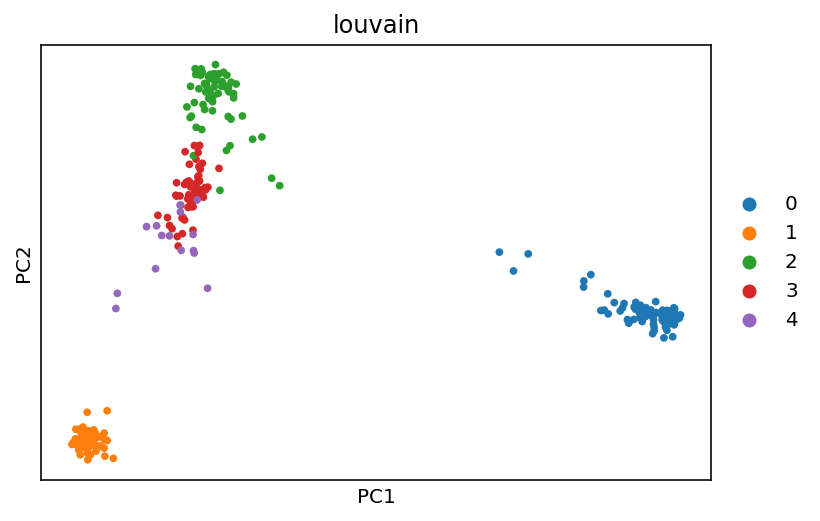

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.louvain(adata)
sc.pl.pca(adata, color='louvain', size=60)

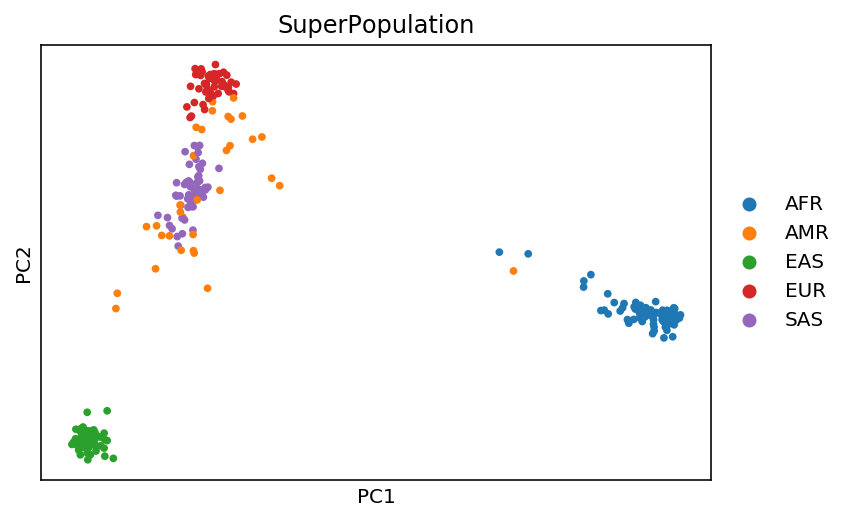

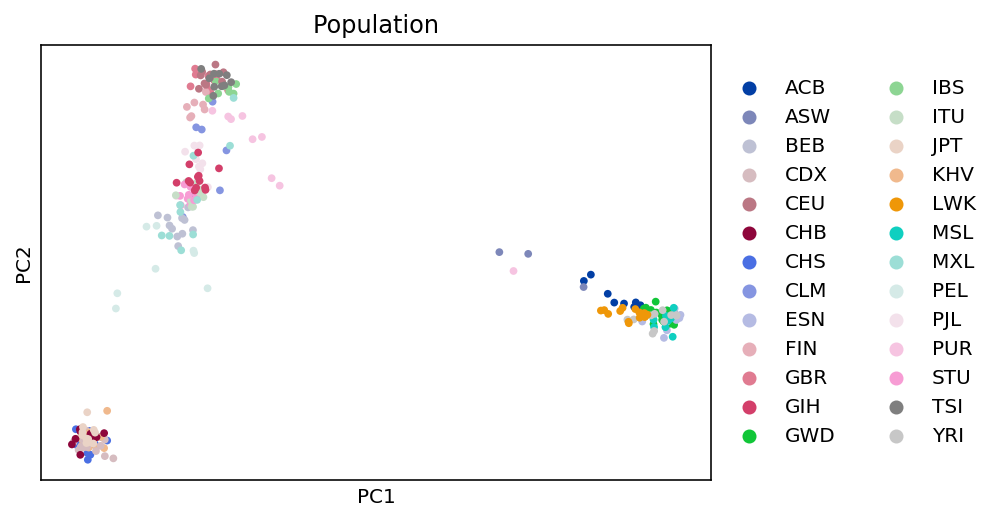

In [17]:
sc.pl.pca(adata, color='SuperPopulation', size=60)
sc.pl.pca(adata, color='Population', size=60)

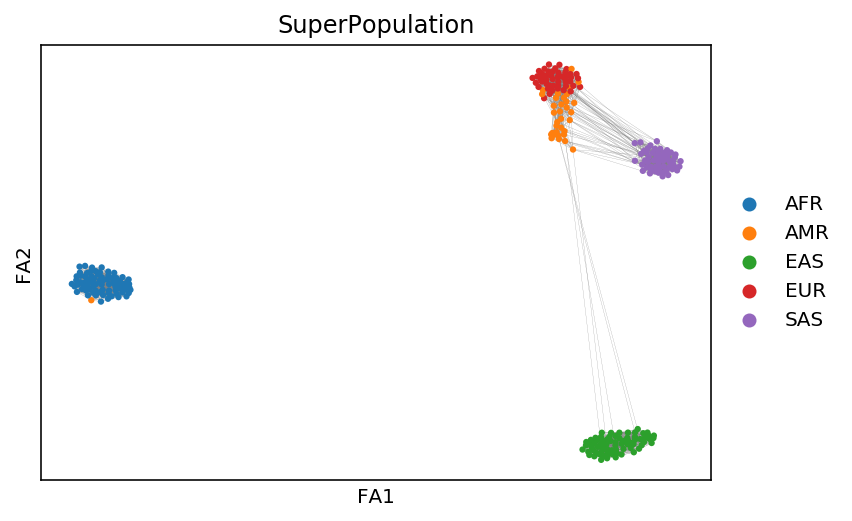

In [18]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='SuperPopulation', size=40, edges=True)

In [19]:
adata.obs['PurpleHair'] = adata.obs['PurpleHair'].astype('category')
adata.obs['isFemale'] = adata.obs['isFemale'].astype('category')

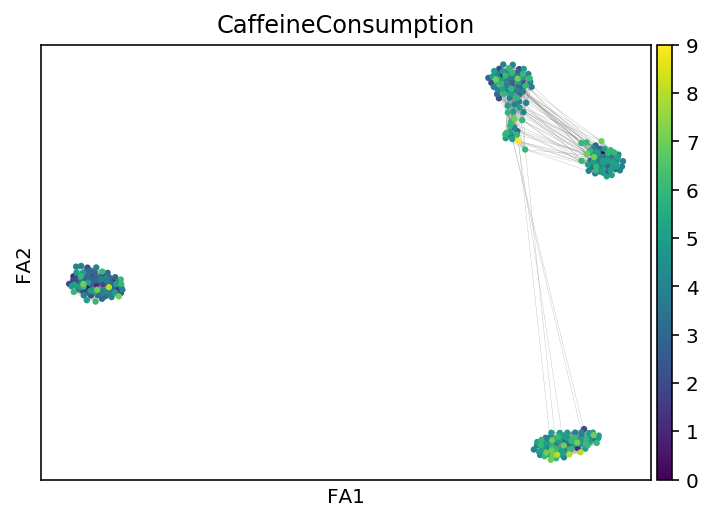

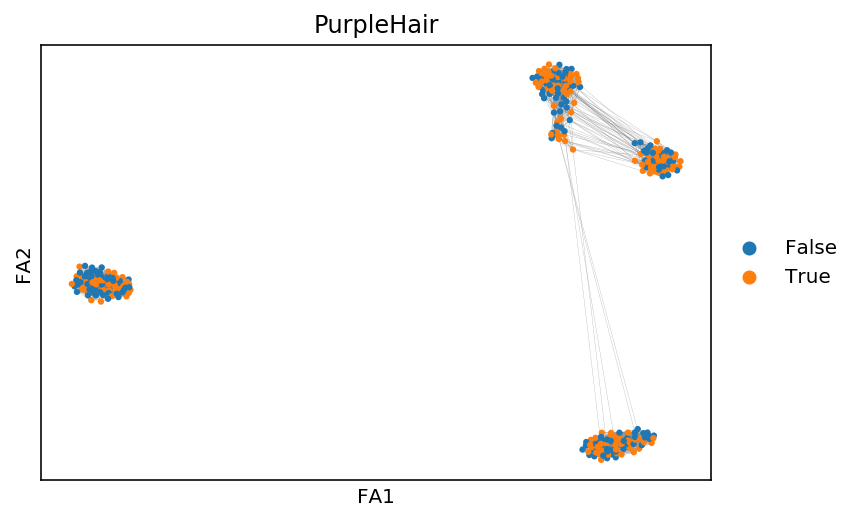

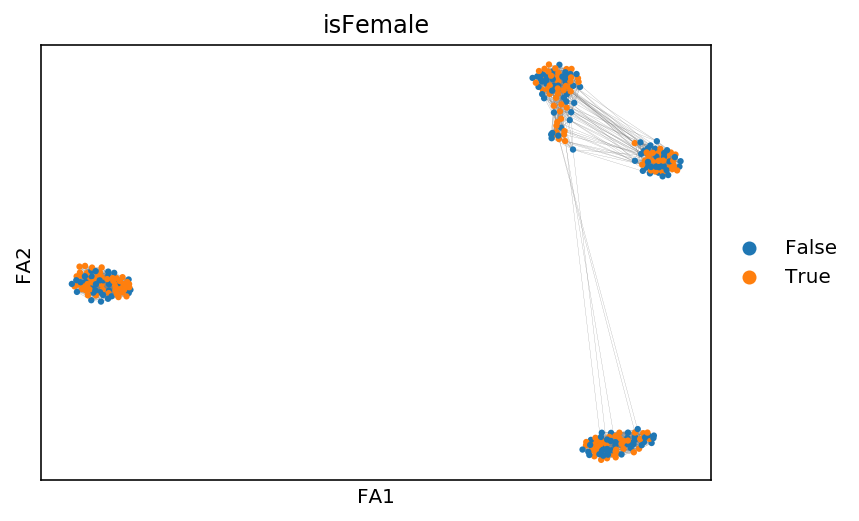

In [20]:
sc.pl.draw_graph(adata, color='CaffeineConsumption', size=40, edges=True)
sc.pl.draw_graph(adata, color='PurpleHair', size=40, edges=True)
sc.pl.draw_graph(adata, color='isFemale', size=40, edges=True)

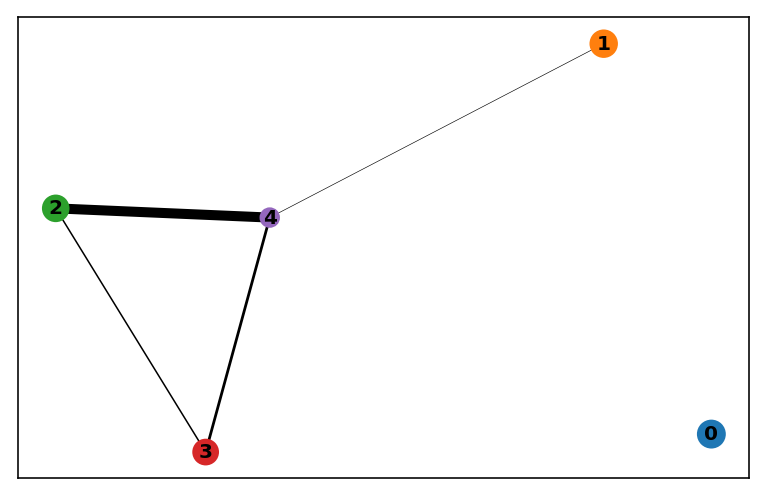

In [21]:
sc.tl.paga(adata)
sc.pl.paga(adata)

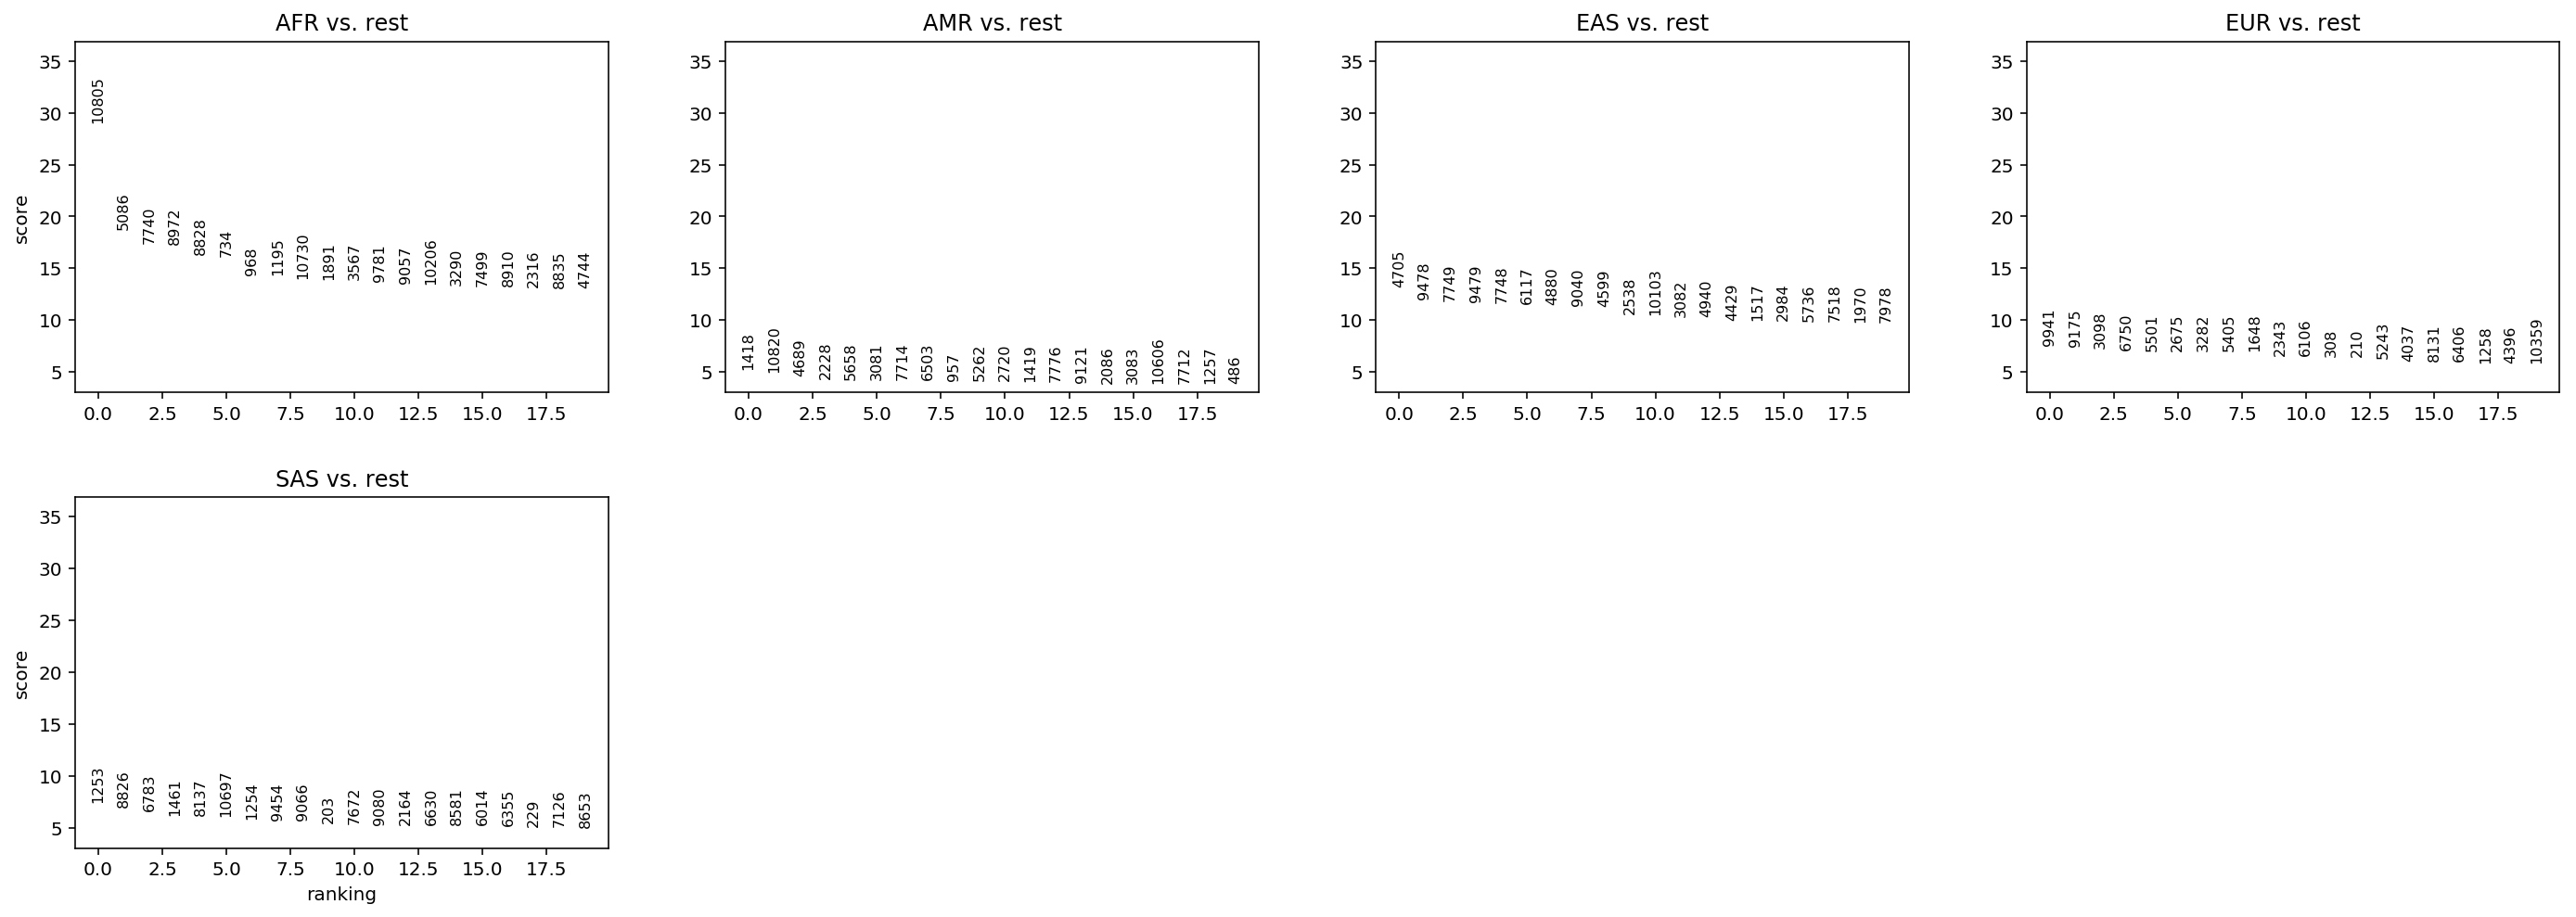

In [22]:
adata.var.reset_index(drop=True, inplace=True)
sc.tl.rank_genes_groups(adata, 'SuperPopulation')
sc.pl.rank_genes_groups(adata)

### LD

/Users/gokcen/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


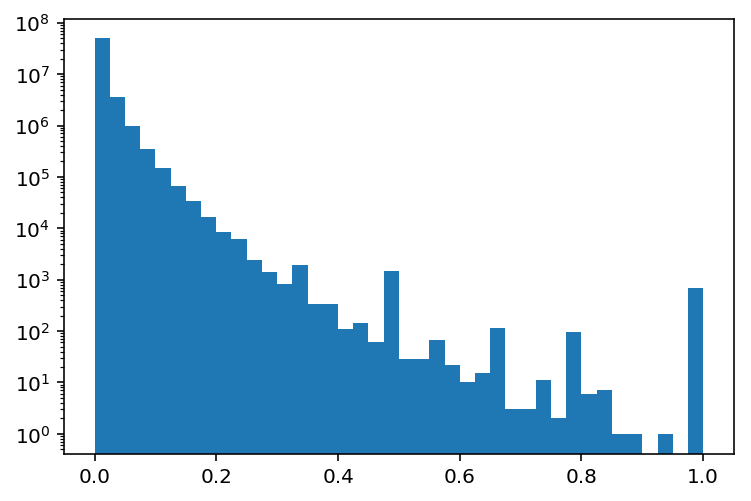

In [23]:
c = np.corrcoef(adata.X.T)**2 # squared variant correlations
c2 = c[np.triu_indices(len(c), 1)]

plt.hist(c2[~np.isnan(c2)], bins=40);
plt.yscale("log", nonposy='clip')

## From Anndata to MatrixTable

In [24]:
def ad2mt(adata):
    mt = hl.utils.range_matrix_table(n_rows=adata.n_obs, n_cols=adata.n_vars)
    print(mt.count())

    # first, add row and col keys to mt
    mt = mt.key_cols_by(col_idx=hl.literal(adata.var.index.values.tolist())[hl.int(hl.scan.count())])
    mt = mt.key_rows_by(row_idx=hl.literal(adata.obs.index.values.tolist())[hl.int(hl.scan.count())])

    # import var and obs columns one by one to the mt using the common index
    vart = hl.Table.from_pandas(adata.var.reset_index(), 'index')
    for var in adata.var_keys():
        mt = mt.annotate_cols(**{var: vart[mt.col_idx][var]})

    obst = hl.Table.from_pandas(adata.obs.reset_index(), 'index')
    for obs in adata.obs_keys():
        mt = mt.annotate_rows(**{obs: obst[mt.row_idx][obs]})
    
    # annotate entries
    df = pd.DataFrame(adata.X, columns=adata.var.index, index=adata.obs.index).reset_index()
    df = df.melt(id_vars='index',var_name='col_idx', value_name='X').rename(columns={'index': 'row_idx'})

    df_t = hl.Table.from_pandas(df)
    mt.annotate_entries(x=df_t[mt.row_idx, mt.col_idx])

    return mt